 # Audio mnist classification


Credits to https://github.com/markovka17/apdl/blob/master/week01/

In [1]:
# !pip install torchaudio==0.10

In [2]:
from matplotlib import pyplot as plt
from IPython import display

import torch
import torchaudio

import numpy as np

In [3]:
assert torch.__version__.startswith('1.1'), 'Please, install torch>=1.8'
assert torchaudio.__version__.startswith('0.1'), 'Please, install torchaudio>=0.8'

In [4]:
torchaudio.__version__

'0.10.0a0+ab97afa'


![](https://i.imgur.com/OX1ADxu.png)



Uncomment to download data

In [5]:
# !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1NlEMrCLzVQE-7p7bwhgXV6_yHhWXJcXm' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1NlEMrCLzVQE-7p7bwhgXV6_yHhWXJcXm" -O AudioMNIST.zip && rm -rf /tmp/cookies.txt

Uncomment to unzip archive

In [6]:
# !unzip AudioMNIST.zip

In [39]:
from typing import List, Tuple

import pathlib
from tqdm import tqdm
from itertools import islice
from collections import defaultdict
from IPython.display import Audio

import torch
import torch.nn.functional as F
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader, Subset

Определим класс AudioMnistDataset для загрузки данных. При загрузке извлечем из названия файла `label` аудио - произносимую цифру - первый символ в аудио до знака "_"

In [40]:
paths = list(pathlib.Path('AudioMNIST/').rglob('?_*_*.wav'))
wav, sr = torchaudio.load(paths[0])

In [41]:
Audio(wav, rate=sr)

In [42]:
sr

16000

In [43]:
SAMPLE_RATE = sr

In [44]:
class AudioMnistDataset(Dataset):
    SR = SAMPLE_RATE
    
    """
    Each wavfile has the following format: digit_speackerid_wavid.wav
        For example, 6_01_47.wav:
            6 -- the number 6 is spoken
            01 -- the number is spoken by 1 speaker
            47 -- id of wavfile        
    """
    
    def __init__(self, path_to_data: str):
        self.path_to_data = pathlib.Path(path_to_data)
        self.paths = list(self.path_to_data.rglob('?_*_*.wav'))
    
    def __getitem__(self, index: int):
        path_to_wav = self.paths[index].as_posix()
        
        # Load wav
        wav, sr = torchaudio.load(path_to_wav)
        
        label = int(path_to_wav.split('/')[-1].split('_')[0])
        
        return wav, label
    
    def __len__(self):
        return len(self.paths)


In [45]:
dataset = AudioMnistDataset('AudioMNIST')

In [46]:
len(dataset)

30000

In [47]:
wav, label = dataset[123]
label

9

Разобъем датасет на датасеты для трейна и валидации.

In [48]:
train_ratio = 0.9
train_size = int(len(dataset) * train_ratio)
validation_size = len(dataset) - train_size

indexes = torch.randperm(len(dataset))
train_indexes = indexes[:train_size]
validation_indexes = indexes[train_size:]

train_dataset = Subset(dataset, train_indexes)
validation_dataset = Subset(dataset, validation_indexes)

In [49]:
assert not set(train_indexes.tolist()).intersection(set(validation_indexes.tolist()))

Класс Collator объединяет аудиодорожки в один батч. Так как в нашей задаче все аудио разной длины, для того чтобы собрать в батч, заполним недостающее нулями (сделаем паддинг). Для этого создадим тензор из нулей размера `[batch_size, max_wav_len]` и заполним его элементами батча.

In [50]:
class Collator:
    
    def __call__(self, batch: List[Tuple[torch.Tensor, int]]):
        lengths = []
        wavs, labels = zip(*batch)
        
        for wav in wavs:
            lengths.append(wav.size(-1))
        
        max_len = max(lengths)
        batch_wavs = torch.zeros(len(batch), max_len)
        for i, (wav, length) in enumerate(zip(wavs, lengths)):
            batch_wavs[i, :length] = wav.squeeze()
            
        labels = torch.tensor(labels).long()
        lengths = torch.tensor(lengths).long()
        
        return {
            'wav': batch_wavs,
            'label': labels,
            'length': lengths,
        }

In [51]:
train_dataloader = DataLoader(
    train_dataset, batch_size=32,
    shuffle=True, collate_fn=Collator(),
    num_workers=2, pin_memory=True
)

validation_dataloader = DataLoader(
    validation_dataset, batch_size=32,
    collate_fn=Collator(),
    num_workers=2, pin_memory=True
)

Класс Featurizer делает необходимый в нашей задаче препроцессинг - считаем мел спектрограмму, логарифмирует ее и считает длину спектрограммы.

In [52]:
NUM_MELS = 80
HOP_LEN = 256
N_FFT = 1024
WIN_LEN = N_FFT

In [53]:
class Featurizer(nn.Module):
    
    def __init__(self):
        super(Featurizer, self).__init__()
        
        self.featurizer = torchaudio.transforms.MelSpectrogram(
            sample_rate=SAMPLE_RATE,
            n_fft=N_FFT,
            win_length=WIN_LEN,
            hop_length=HOP_LEN,
            n_mels=NUM_MELS,
        )
        
    def forward(self, wav, length=None):
        mel_spectrogram = self.featurizer(wav)
        mel_spectrogram = mel_spectrogram.clamp(min=1e-5).log()
        
        if length is not None:
            length = (length - self.featurizer.win_length) // self.featurizer.hop_length
            # We add `4` because in MelSpectrogram center==True
            length += 1 + 4
            
            return mel_spectrogram, length
        
        return mel_spectrogram


 - В модель приходит батч размера [batch_size, num_mels, seq_len].
 - В начале используем последовательность одномерных сверточных слоев с Relu активацией.
 - После следует реккурентный блок lstm. Он возвращает кортеж тензоров `out, (hn, cn)`, где `out` - скрытые состояния для всех элементов последовательности, `h_n, c_n` - скрытое состояние и cell state последнего элемента последовательности.
Так как длина последовательности, то есть длина спектрограммы всегда различна, для классификации будем использовать скрытое состояние последнего элемента последовательности, как содержащее главную информацию о всей последовательности. При этом мы теряем информацию о каждом элементе последовательности, что в данной задаче некритично. Но для более сложной задачил лучше использовать `out`, аггрегировав его(усреднив или просуммировав) вдоль размерности seq_len `out.mean(dim=1).`

- Последний слой - слой для классификации, возвращающий тензор размера `[batch_size, NUM_CLASSES]`.


In [59]:
class Model(nn.Module):
    
    def __init__(self, input_dim, num_channels):
        super().__init__()
        self.input_dim = input_dim
        self.num_channels = num_channels

        self.convolutions = nn.Sequential(
            nn.Conv1d(in_channels=input_dim, out_channels=num_channels, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv1d(in_channels=num_channels, out_channels=num_channels, kernel_size=3, stride=1),
            nn.ReLU(),
        )

        self.rnn = nn.LSTM(input_size=num_channels, hidden_size=num_channels, batch_first=True)

        self.clf = nn.Linear(num_channels, 10)
    
    def forward(self, inputs, length=None):
        # inputs of shape [batch_size, num_mels, seq_len]
        x  = self.convolutions(inputs)  # x [batch_size, num_channels, seq_len]
        
        x = x.transpose(1, 2) # x [batch_size, seq_len, num_channels]

        out, (hn, cn) = self.rnn(x) # h_n of shape [1, batch_size, hidden_size]

        hn = hn.squeeze(0) # h_n of shape [batch_size, hidden_size]

        logits = self.clf(hn)
        return logits

Зададим параметры модели и оптимизатора и функцию потерь

In [60]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = Model(input_dim=NUM_MELS, num_channels=32).to(device)
featurizer = Featurizer().to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()



Создадим класс для подсчета метрики 

In [61]:
class AverageMeter(object):
    """
    Computes and stores the average and current value
    """
    
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


In [62]:
storage = defaultdict(list)
num_epoch = 10

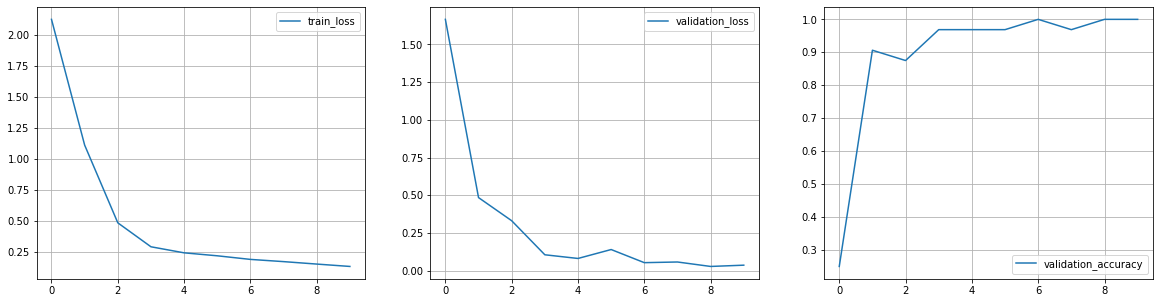

In [28]:
for epoch in range(num_epoch):
    train_loss_meter = AverageMeter()
    print(f"Epoch {epoch} out of {num_epoch}")

    model.train()
    for i, batch in enumerate(tqdm(train_dataloader)):
        # Move batch to device if device != 'cpu'
        wav = batch['wav'].to(device)
        length = batch['length'].to(device)
        label = batch['label'].to(device)

        # Compute mel spectrogram
        mel, mel_length = featurizer(wav, length)

        # feed model
        output = model(mel, mel_length)

        # compute loss
        loss = criterion(output, label)

        # zero out previously computed gradients
        optimizer.zero_grad()

        # compute gradients
        loss.backward()
    
        # update weights
        optimizer.step()

        # update metrics
        train_loss_meter.update(loss.item())
        
    storage['train_loss'].append(train_loss_meter.avg)
    
    validation_loss_meter = AverageMeter()
    validation_accuracy_meter = AverageMeter()

    model.eval()
    for i, batch in islice(enumerate(tqdm(validation_dataloader)), 1):
        # Move batch to device if device != 'cpu'
        wav = batch['wav'].to(device)
        length = batch['length'].to(device)
        label = batch['label'].to(device)

        # in inference mode we don't need to compute gradients
        # so we use `no_grad()` context manager to speed up inference
        with torch.no_grad():

            mel, mel_length = featurizer(wav, length)
            output = model(mel, mel_length)

            loss = criterion(output, label)
        
        # compute accuracy
        matches = (output.argmax(dim=-1) == label).float().mean()

        validation_loss_meter.update(loss.item())
        validation_accuracy_meter.update(matches.item())
    
    storage['validation_loss'].append(validation_loss_meter.avg)
    storage['validation_accuracy'].append(validation_accuracy_meter.avg)
    
    display.clear_output()
    
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].plot(storage['train_loss'], label='train_loss')
    axes[1].plot(storage['validation_loss'], label='validation_loss')

    axes[2].plot(storage['validation_accuracy'], label='validation_accuracy')

    for i in range(3):
        axes[i].grid()
        
        axes[i].legend()

    plt.show()

